In [1]:
import numpy as np 
import torch
import os
import copy

from joblib import load
from torch.nn import DataParallel
from util.loss_func import LpLoss
from util.HNO_GNO import UNO3D
from util.load_data import get_chunk_data_surf
from util.figplot import plot_fwi_result
from util.fwi import auto_diff_FWI, laplacian_reg
from util.prep_data import InputNormalizer

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "6, 7"
device = torch.device('cuda')
device_ids = [0, 1]

In [2]:
eps = 0
fs = 20
fn = fs / 2  # Nyquist frequency
dt = 1 / fs
start_time_in_seconds = -0.5
end_time_in_seconds = 2.0
T = round((end_time_in_seconds - start_time_in_seconds) / dt + 1)
n_after_padding = T
freqs = torch.arange(n_after_padding // 2 + 1) * fs / (n_after_padding - 1)
ws = 2 * torch.pi * freqs
freq_to_keep = list(range(5, torch.where(freqs>=6)[0][0].item() + 1))
NF = len(freq_to_keep)

nx, ny, nz = 64, 64, 64
xcoor, ycoor, zcoor = torch.linspace(0, 5000, nx), torch.linspace(0, 5000, ny), torch.linspace(0, 5000, nz)
xx, yy, zz = torch.meshgrid(xcoor, ycoor, zcoor, indexing='ij')

in_channels = 5
out_channels = 6
width = 32
nsrc = 30

In [3]:
model = UNO3D(in_channels+3, width, pad=0)
model.to(device)
model = DataParallel(model, device_ids=device_ids)
model.load_state_dict(torch.load("../model/HNO_GNO_3D.pth"))

x_standardizer = load("../model/x_standardizer_surf.sav")
y_standardizer = load("../model/y_standardizer_surf.sav")


In [4]:
data_in, data_out = get_chunk_data_surf(offset=0, chunk_size=nsrc,
                                        NF=NF, nx=nx, ny=ny, nz=nz, in_channels=in_channels, out_channels=out_channels,
                                        inputpath="../data/input_fwi_surf", 
                                        outputpath="../data/output_fwi_surf")
vp = copy.deepcopy(data_in[0, :, :, :, 0])
vp = vp * (x_standardizer.std[0].unique().item() + x_standardizer.eps) + x_standardizer.mean[0].unique().item()
vs = copy.deepcopy(data_in[0, :, :, :, 1])
vs = vs * (x_standardizer.std[1].unique().item() + x_standardizer.eps) + x_standardizer.mean[1].unique().item()
data_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        data_in,
        data_out),
    batch_size=16,
    shuffle=True)

In [5]:
fwi = auto_diff_FWI().to(device)
optimizer = torch.optim.Adam(fwi.parameters(), lr=0.03)


In [6]:
L2 = LpLoss(p=2, size_average=False)  
L1 = LpLoss(p=1, size_average=False)

lam = 1e-4  # coefficient of Laplacian regularization

nepoch = 50
loss_inv = np.zeros(nepoch)
rel_l2_inv = np.zeros(nepoch)

fwi.train()
model.eval()
for i in range(nepoch):  
    inv_loss = 0.0
    inv_rel_l2 = 0.0
    for x, y in data_loader:
        x, y = x.to(device), y[:, :, :, 0, :].to(device)
        optimizer.zero_grad()
        out = fwi(x, model)[:, :, :, 0, :]
        L2_loss = L2(out, y)
        L1_loss = L1(out, y)
        loss = 0.9 * L1_loss + 0.1 * L2_loss
        
        reg = 0
        for param in fwi.parameters():
            reg += laplacian_reg(param)
        
        loss += lam * reg
        loss.backward()
        optimizer.step()
        inv_loss += loss.item() 
        inv_rel_l2 += L2_loss.item() 
    
    loss_inv[i] = inv_loss / data_in.shape[0]
    rel_l2_inv[i] = inv_rel_l2 / data_in.shape[0]


In [7]:
vs_inv, vp_inv = list(fwi.parameters())[0].cpu().detach().numpy(), list(fwi.parameters())[1].cpu().detach().numpy()
vs_inv = vs_inv * (x_standardizer.std[1].unique().item() + x_standardizer.eps) + x_standardizer.mean[1].unique().item()
vp_inv = vp_inv * (x_standardizer.std[0].unique().item() + x_standardizer.eps) + x_standardizer.mean[0].unique().item()

srcxyz = np.zeros((nsrc, 3))
for i in range(nsrc):
    srcxyz[i] = np.load("../data/src_fwi_surf{}.npy".format(i))

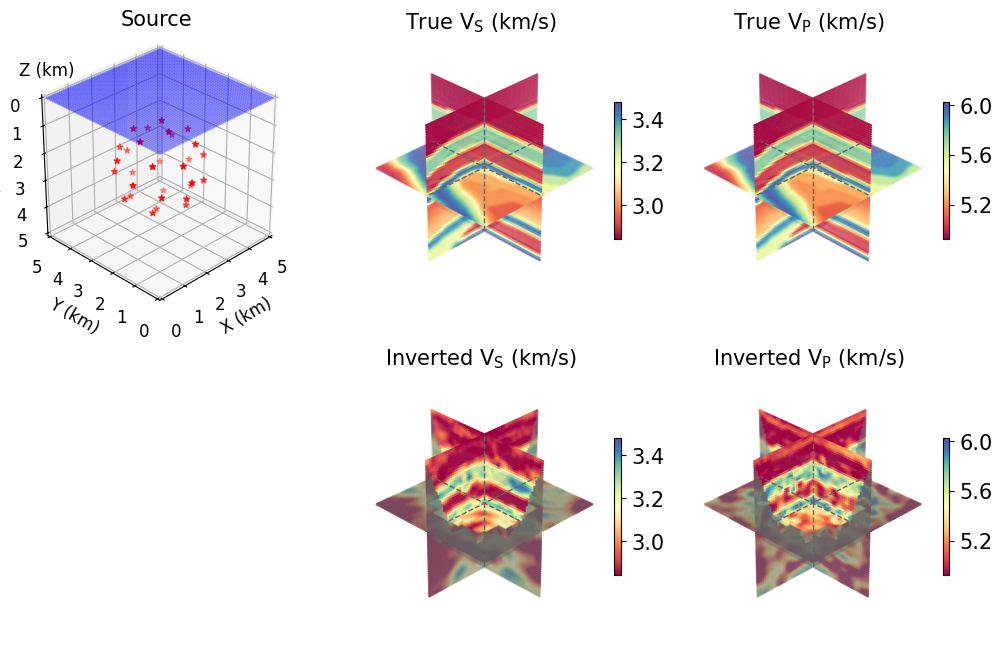

In [8]:
ncover = np.load("../data/ray_coverage.npy")
index = ((xx.numpy() == xx.unique()[nx//2].item()) | (yy.numpy() == yy.unique()[ny//2].item())| (zz.numpy() == zz.unique()[nz//2].item()))
plot_fwi_result(srcxyz, vs, vp, vs_inv, vp_inv, index, ncover, shade=True)